In [1]:
import struct
import numpy as np
import pandas as pd  
import random
import matplotlib.pyplot as plt
from math import *
from astropy.io import fits
import astropy.constants as c
import astropy.units as u
import scipy.constants as spc

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

<font color=black size=3 face=Times>
1.binary in isothermal potential 

isothermal potential $\phi=2\sigma^2\ln(r)+const$

$$
\frac{d}{dt^{\prime}}
\left(
 \begin{matrix}
   x^{\prime}\\
   y^{\prime}\\
   z^{\prime}\\
   v^{\prime}_x\\
   v^{\prime}_y\\
   v^{\prime}_z
  \end{matrix}
\right)
=
\left(
 \begin{matrix}
   v^{\prime}_x\\
   v^{\prime}_y\\
   v^{\prime}_z\\
   -\frac{x^{\prime}}{x^{\prime2}+y^{\prime2}+z^{\prime2}}\\
   -\frac{y^{\prime}}{x^{\prime2}+y^{\prime2}+z^{\prime2}}\\
   -\frac{z^{\prime}}{x^{\prime2}+y^{\prime2}+z^{\prime2}}\\
  \end{matrix}
\right)
$$

normalization：

${\bf{r}}^{\prime}={\bf{r}}/R_c$

$t^{\prime}=t/\frac{R_c}{\sqrt{2}\sigma}$

$R_c=\frac{GM_c}{2\sigma^2}$

In [2]:
def diff_equation1( x_list , t ):
    x,y,z,vx,vy,vz=x_list
    return np.array([ vx , vy , vz , -x/(x**2+y**2+z**2) ,  -y/(x**2+y**2+z**2) , -z/(x**2+y**2+z**2) ])

<font color=black size=3 face=Times>
2. dynamical friction
    
$$
\frac{d{\bf{v}}_M}{dt}=D[\Delta{\bf{v}}]
$$

$$
\frac{d{\bf{v}}_M}{dt}=-\frac{4\pi G^2M\rho \ln{\Lambda}}{v^3_M}[erf(X)-\frac{2X}{\sqrt{\pi}}e^{-X^2}]{\bf{v}}_M
$$
where, $\rho=\frac{\sigma^2}{2\pi Gr^2}$, $\Lambda=N?$, $X=v_M/\sqrt{2}\sigma$, use normalization

$$
\frac{d{\bf{v}}_M^{\prime}}{dt^{\prime}}=-\frac{M^{\prime}\ln\Lambda}{v^{\prime3}_M r^{\prime2}}[erf(X)-\frac{2X}{\sqrt{\pi}}e^{-X^2}]{\bf{v}}^{\prime}_M
$$
where $M^{\prime}=M/M_c$


In [3]:
M_prime=20/10**5
Lambda=10**5

def diff_equation2( x_list , t ):
    x,y,z,vx,vy,vz=x_list
    
    v_m=sqrt(vx**2+vy**2+vz**2)
    r=sqrt(x**2+y**2+z**2)
    
#     Lambda=r/M_prime
    a_f=M_prime*log(Lambda)/v_m**3/r**2*(erf(v_m)-2*v_m/sqrt(pi)*e**(-v_m**2))
    
    return np.array([ vx , vy , vz , -x/r**2-a_f*vx ,  -y/r**2-a_f*vy , -z/r**2-a_f*vz ])

$a' = a/R_c \qquad \frac{dP}{dt'}=\frac{M'a'\Lambda}{16 \sqrt{(1+2*v'^2)} \, r'^2} \qquad \delta v'  = \sqrt{\frac{0.05 }{a'\Lambda }} \qquad \delta a' = - \frac{2}{7}a'$

In [4]:
M_prime=20/10**5
Lambda=1*10**5
ep = 0.01

def diff_equation3(t, x_list):
    x,y,z,vx,vy,vz,P,a=x_list
    
    v_m=sqrt(vx**2+vy**2+vz**2)
    r=sqrt(x**2+y**2+z**2)
    
    a_f = M_prime*log(Lambda)/v_m**3/(r**2+ep**2)*(erf(v_m)-2*v_m/sqrt(pi)*e**(-v_m**2))
    
    dP = M_prime*a*Lambda/(16*sqrt(1+2*v_m**2)*(r**2+ep**2))
    
    return np.array([ vx , vy , vz , -x/(r**2+ep**2)-a_f*vx,  -y/(r**2+ep**2)-a_f*vy, -z/(r**2+ep**2)-a_f*vz, dP , 0 ])

def encounter(t, y):
    return y[6]-1

In [ ]:
tspan = [0, 2000]
ini3=[0.5,0,0,0,0.5,0.5,0,(0.1*u.au/u.pc).cgs]
Result=[[],[],[],[],[],[],[],[],[]]

for i in range(10):
    
    encounter.terminal = True

    result3=solve_ivp(diff_equation3,tspan,ini3,'RK45',events=encounter,max_step=0.01)
    result3t = result3.t
    result3y = result3.y
    re1 = np.vstack((result3t,result3y))
    Result = np.hstack((Result,re1))
    
    ye = result3y[:,-1]
    a = ye[7]
    
    if len(result3.t_events[0]) !=0:
        
        t0 = result3.t_events[0][0]
        e0 = np.random.random(3)
        e1 = e0/np.linalg.norm(e0)
        dvx, dvy, dvz = sqrt(0.05/a/Lambda)*e1[0], sqrt(0.05/a/Lambda)*e1[1], sqrt(0.05/a/Lambda)*e1[2]
        da = -2/7*a
        ye[6] = 0
        
    else:
        t0 =result3t[-1]
        dvx, dvy, dvz, da = 0, 0, 0, 0
        
    ye[3], ye[4], ye[5], ye[7] = ye[3]+dvx, ye[4]+dvy, ye[5]+dvz, a+da
    tspan = [t0, t0+2000.0]
    ini3 = ye

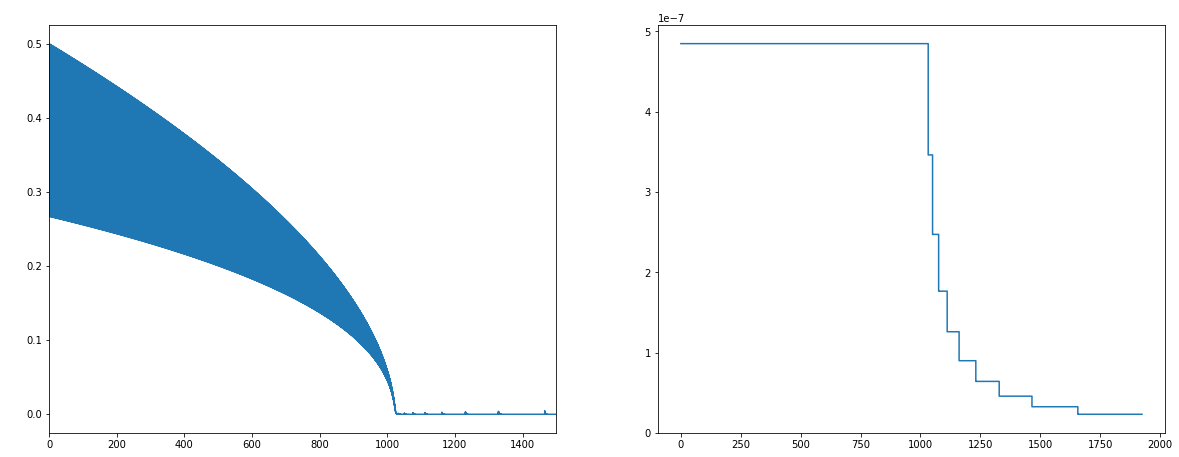

In [68]:
r_list3=np.sqrt(Result[1,:]**2+Result[2,:]**2+Result[3,:]**2)
v_list3=np.sqrt(Result[4,:]**2+Result[5,:]**2+Result[6,:]**2)
t, P_list3, a_list3=Result[0,:], Result[7,:], Result[8,:]

fig = plt.figure(figsize=(20,7.5))

ax1=fig.add_subplot(121)
ax1.plot(t,r_list3)
plt.xlim([0,1500])
ax1.set_ylabel(' ',fontsize=16)
ax1.set_title(' ',fontsize=16)

ax1=fig.add_subplot(122)
ax1.plot(t,a_list3)
ax1.set_ylabel('')
ax1.set_ylabel(' ',fontsize=16)
ax1.set_title(' ',fontsize=16)
plt.savefig('1.png')
plt.show()